In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto
from scipy.optimize import minimize
import seaborn as sns
import scipy.stats as ss
from pandas.plotting import scatter_matrix
import matplotlib as mpl


# Set seed
np.random.seed(42)

## Initial Set Up

In [ ]:
df = pd.read_csv('df_fuel_ckan.csv')

# Convert the DATETIME column to datetime format
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

# Set the DATETIME column as the index
df.set_index('DATETIME', inplace=True)
# Resample to daily data
df_daily = df.resample('D').sum()

# Create a time index and extract day-of-year for seasonal indicators
df_daily['t'] = np.arange(len(df_daily))
df_daily['dayofyear'] = df_daily.index.dayofyear

# Define seasonal indicators based on day-of-year:
df_daily['summer'] = ((df_daily['dayofyear'] >= 150) & (df_daily['dayofyear'] <= 240)).astype(int)
df_daily['autumn'] = ((df_daily['dayofyear'] > 240) & (df_daily['dayofyear'] <= 330)).astype(int)
df_daily['winter'] = ((df_daily['dayofyear'] > 330) | (df_daily['dayofyear'] <= 60)).astype(int)
# Spring is the baseline
df_daily['spring'] = 1 - (df_daily['summer'] + df_daily['autumn'] + df_daily['winter'])

window = 30

# Calculate the rolling average 
df_daily['trend'] = df_daily['RENEWABLE'].rolling(window=window, center=True, min_periods=window//2).mean()

# Detrend by subtracting the rolling average from the original data
df_daily['detrended'] = df_daily['RENEWABLE'] - df_daily['trend']

df_daily['rolling_mean'] = df_daily['RENEWABLE'].rolling(window=window, center=True, min_periods=window//2).mean()
df_daily['rolling_std'] = df_daily['RENEWABLE'].rolling(window=window, center=True, min_periods=window//2).std()

# Standardize the data
df_daily['std_detrended'] = (df_daily['RENEWABLE'] - df_daily['rolling_mean']) / df_daily['rolling_std']

## Simulate a new series using Empirical‐Bootstrap

In [4]:
X = df_daily['std_detrended'].values
t = df_daily['t'].values
summer = df_daily['summer'].values
autumn = df_daily['autumn'].values
winter = df_daily['winter'].values
spring = df_daily['spring'].values


In [ ]:
def mean_excess(data, k):
    # Calculate the mean excess above threshold k
    exceedances = data[data > k] - k
    return np.mean(exceedances) if len(exceedances) > 0 else np.nan

def loglik_tail(params, Y, t, summer, autumn, winter):
    sigma_params = params[:-1]
    xi = params[-1]
    sigma_values = sigma_t(sigma_params, t, summer, autumn, winter)
    if np.any(1 + xi * (Y / sigma_values) <= 0):
        return np.inf
    term1 = -np.log(sigma_values)
    term2 = -(1 + 1 / xi) * np.log(1 + xi * (Y / sigma_values))
    return -np.sum(term1 + term2)

def sigma_t(params, t, summer, autumn, winter):
    sigma_0, beta_1, beta_2, beta_3, beta_4 = params
    return np.maximum(sigma_0 + beta_1 * t + beta_2 * summer + beta_3 * autumn + beta_4 * winter, 1e-10)

def simulate_data(params, t, summer, autumn, winter):
    sigma_params = params[:-1]
    xi = params[-1]
    sig = sigma_t(sigma_params, t, summer, autumn, winter)
    # Generate uniform random variables
    U = np.random.uniform(0, 1, size=len(t))
    # Use the inverse CDF of the generalized Pareto distribution.
    if np.abs(xi) > 1e-8:
        X_sim = sig * (((1 - U) ** (-xi)) - 1) / xi
    else:
        X_sim = sig * (-np.log(1 - U))
    return X_sim

In [ ]:
sigma0_true, beta1_true, beta2_true, beta3_true, beta4_true, xi_true = (0.3, 0.0, 0.1, 0.02, 0.1, -0.1)

# Compute real data threshold and locate exceedance indices
u_real = np.quantile(X, 0.975)
tail_indices = np.where(X > u_real)[0]
n_exc = len(tail_indices)

# MLE and bootstrap settings
n_simulations = 1000
n_boot = 100
bounds = [
    (0.0, None),
    (None, None),
    (None, None),
    (None, None),
    (None, None),
    (-1, 1)  
]

simulation_results = []

for sim in range(n_simulations):
    # Simulate new GPD excesses Y_sim at the same tail locations
    t_exc = t[tail_indices]
    summer_exc = summer[tail_indices]
    autumn_exc = autumn[tail_indices]
    winter_exc = winter[tail_indices]

    sigma_true_at_tail = (
        sigma0_true
        + beta1_true * t_exc
        + beta2_true * summer_exc
        + beta3_true * autumn_exc
        + beta4_true * winter_exc
    )
    sigma_true_at_tail = np.maximum(sigma_true_at_tail, 1e-10)

    U = np.random.rand(n_exc)
    if abs(xi_true) > 1e-8:
        Y_sim = sigma_true_at_tail * ((1 - U)**(-xi_true) - 1) / xi_true
    else:
        Y_sim = sigma_true_at_tail * (-np.log(1 - U))

    # Build the semi series (bulk unchanged, tail replaced)
    X_hybrid = X.copy()
    X_hybrid[tail_indices] = u_real + Y_sim

    # Extract exceedances for MLE
    Y_fit = X_hybrid[tail_indices] - u_real

    me_su = mean_excess(X[summer], u_real)
    me_au = mean_excess(X[autumn], u_real)
    me_sp = mean_excess(X[spring], u_real)
    me_wi = mean_excess(X[winter], u_real)


    sigma0_init = me_sp if not np.isnan(me_sp) else 0.1
    beta1_init  = 0.0
    beta2_init  = (me_su - me_sp) if not np.isnan(me_su) else 0.0
    beta3_init  = (me_au - me_sp) if not np.isnan(me_au) else 0.0
    beta4_init  = (me_wi - me_sp) if not np.isnan(me_wi) else 0.0
    xi_init     = 0.1

    init_params = [sigma0_init, beta1_init, beta2_init, beta3_init, beta4_init, xi_init]

    # Fit MLE to the simulated exceedances
    res = minimize(
        loglik_tail,
        x0=init_params,
        args=(Y_fit, t_exc, summer_exc, autumn_exc, winter_exc),
        method="L-BFGS-B",
        bounds=bounds
    )
    mle_params = res.x  # [σ0_hat, β1_hat, β2_hat, β3_hat, β4_hat, ξ_hat]

    # Bootstrap to get CIs
    boot_estimates = np.zeros((n_boot, 6))
    for i in range(n_boot):
        σ0_hat, β1_hat, β2_hat, β3_hat, β4_hat, ξ_hat = mle_params

        sigma_hat_at_tail = np.maximum(
            σ0_hat
            + β1_hat * t_exc
            + β2_hat * summer_exc
            + β3_hat * autumn_exc
            + β4_hat * winter_exc,
            1e-10
        )

        Ub = np.random.rand(n_exc)
        if abs(ξ_hat) > 1e-8:
            Yb = sigma_hat_at_tail * ((1 - Ub)**(-ξ_hat) - 1) / ξ_hat
        else:
            Yb = sigma_hat_at_tail * (-np.log(1 - Ub))

        X_bootstrap = X.copy()
        X_bootstrap[tail_indices] = u_real + Yb
        Y_boot_fit = X_bootstrap[tail_indices] - u_real
        

        # Fit to bootstrap excesses Yb
        me_sp_b = mean_excess(X_bootstrap[spring], u_real)
        me_su_b = mean_excess(X_bootstrap[summer], u_real)
        me_au_b = mean_excess(X_bootstrap[autumn], u_real)
        me_wi_b = mean_excess(X_bootstrap[winter], u_real)

        

        sigma0_b = me_sp_b if not np.isnan(me_sp_b) else 0.1
        beta1_b  = 0.0
        beta2_b  = (me_su_b - me_sp_b) if not np.isnan(me_su_b) else 0.0
        beta3_b  = (me_au_b - me_sp_b) if not np.isnan(me_au_b) else 0.0
        beta4_b  = (me_wi_b - me_sp_b) if not np.isnan(me_wi_b) else 0.0
        xi_b     = 0.1

        init_b = [sigma0_b, beta1_b, beta2_b, beta3_b, beta4_b, xi_b]

        res_b = minimize(
            loglik_tail,
            x0=init_b,
            args=(Yb, t_exc, summer_exc, autumn_exc, winter_exc),
            method="L-BFGS-B",
            bounds=bounds
        )
        boot_estimates[i, :] = res_b.x
        boot_mean   = np.mean(boot_estimates, axis=0)
        boot_median = np.median(boot_estimates, axis=0)
        

    conf_intervals = np.percentile(boot_estimates, [2.5, 97.5], axis=0)  # has shape (2,6)

    simulation_results.append({
        'MLE': mle_params,
        'CI': conf_intervals,
        'boot_mean': boot_mean,
        'boot_median': boot_median
})

    if sim % 100 == 0:
        print(f"Simulation {sim+1}/{n_simulations} complated")








Simulation 1/1000 complated
Simulation 101/1000 complated
Simulation 201/1000 complated
Simulation 301/1000 complated
Simulation 401/1000 complated
Simulation 501/1000 complated
Simulation 601/1000 complated
Simulation 701/1000 complated
Simulation 801/1000 complated
Simulation 901/1000 complated


Coverage of true parameters within the 95% confidence intervals:
σ0: 947 out of 1000
β1: 938 out of 1000
β2: 947 out of 1000
β3: 929 out of 1000
β4: 937 out of 1000
xi: 825 out of 1000


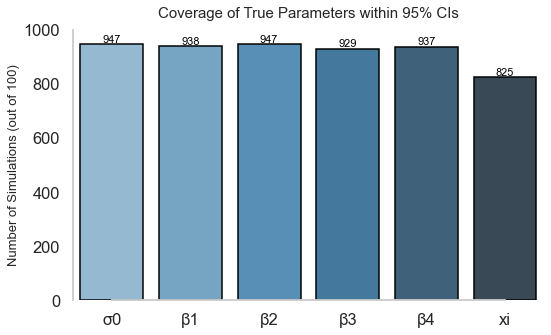

In [ ]:
param_names = ['σ0','β1','β2','β3','β4','xi']
actual_params = np.array([sigma0_true, beta1_true, beta2_true, beta3_true, beta4_true, xi_true])

# Initialize a count array for each parameter
coverage_counts = np.zeros(6)

# Iterate over the simulation results
for sim_result in simulation_results:
    ci = sim_result['CI']  # ci is a 2 x 6 array
    for i in range(6):
        if actual_params[i] >= ci[0, i] and actual_params[i] <= ci[1, i]:
            coverage_counts[i] += 1

# Print out the coverage results 
print("Coverage of true parameters within the 95% confidence intervals:")
for name, count in zip(param_names, coverage_counts):
    print(f"{name}: {int(count)} out of {n_simulations}")

coverage_proportions = coverage_counts / n_simulations


# Plotting the coverage of true parameters within 95% confidence intervals
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.0)


fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(
    x=param_names,
    y=coverage_counts,
    palette="Blues_d",
    edgecolor="black",
    ax=ax
)
ax.set_ylim(0, n_simulations)
ax.set_ylabel("Number of Simulations (out of 100)", fontsize=13)
ax.set_xlabel("") 
ax.set_title("Coverage of True Parameters within 95% CIs", fontsize=15, pad=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Annotate the bars with the coverage counts
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=11,
        color="black"
    )


sns.despine(ax=ax, trim=True)
plt.tight_layout()
plt.show()

In [169]:
conf_ints = np.percentile(boot_estimates, [2.5, 97.5], axis=0)
param_names = ['sigma_0', 'beta_1', 'beta_2', 'beta_3', 'beta_4', 'xi']
for name, ci in zip(param_names, conf_ints.T):
    print(f"{name}: {ci}")

sigma_0: [0.19679106 0.4661322 ]
beta_1: [-2.66671754e-05  5.81861972e-05]
beta_2: [-0.05329914  0.24259142]
beta_3: [-0.09230768  0.22246406]
beta_4: [-2.12795483e-05  3.54218616e-01]
xi: [-0.39542732  0.11997814]


sigma0: mean = 0.2992, median = 0.2864
beta1: mean = -0.0000, median = -0.0000
beta2: mean = 0.0997, median = 0.0885
beta3: mean = 0.0151, median = 0.0169
beta4: mean = 0.0873, median = 0.0676
xi: mean = -0.0590, median = -0.0724


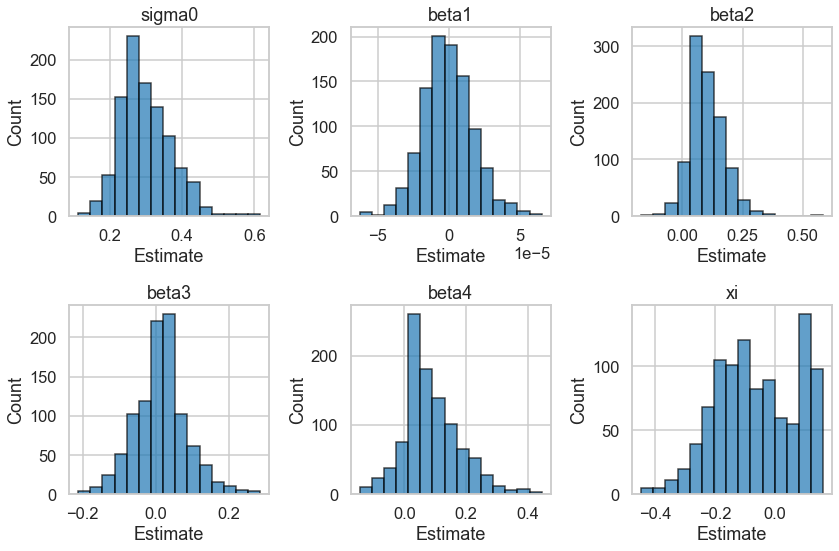

In [ ]:
mle_array = np.vstack([res['MLE'] for res in simulation_results]) 

# Compute column‐wise mean and median
mle_means   = np.mean(mle_array, axis=0)
mle_medians = np.median(mle_array, axis=0)

param_names = ['sigma0', 'beta1', 'beta2', 'beta3', 'beta4', 'xi']

# Results summary
for i, name in enumerate(param_names):
    print(f"{name}: mean = {mle_means[i]:.4f}, median = {mle_medians[i]:.4f}")

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.hist(mle_array[:, i], bins=15, edgecolor='black', alpha=0.7)
    ax.set_title(param_names[i])
    ax.set_xlabel('Estimate')
    ax.set_ylabel('Count')
    ax.grid(True)

plt.tight_layout()
plt.show()




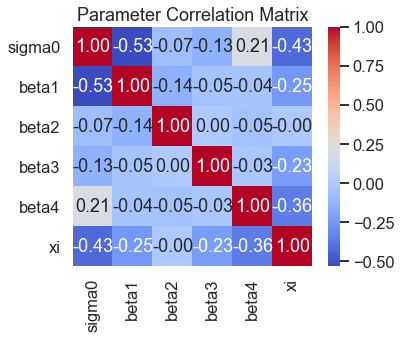

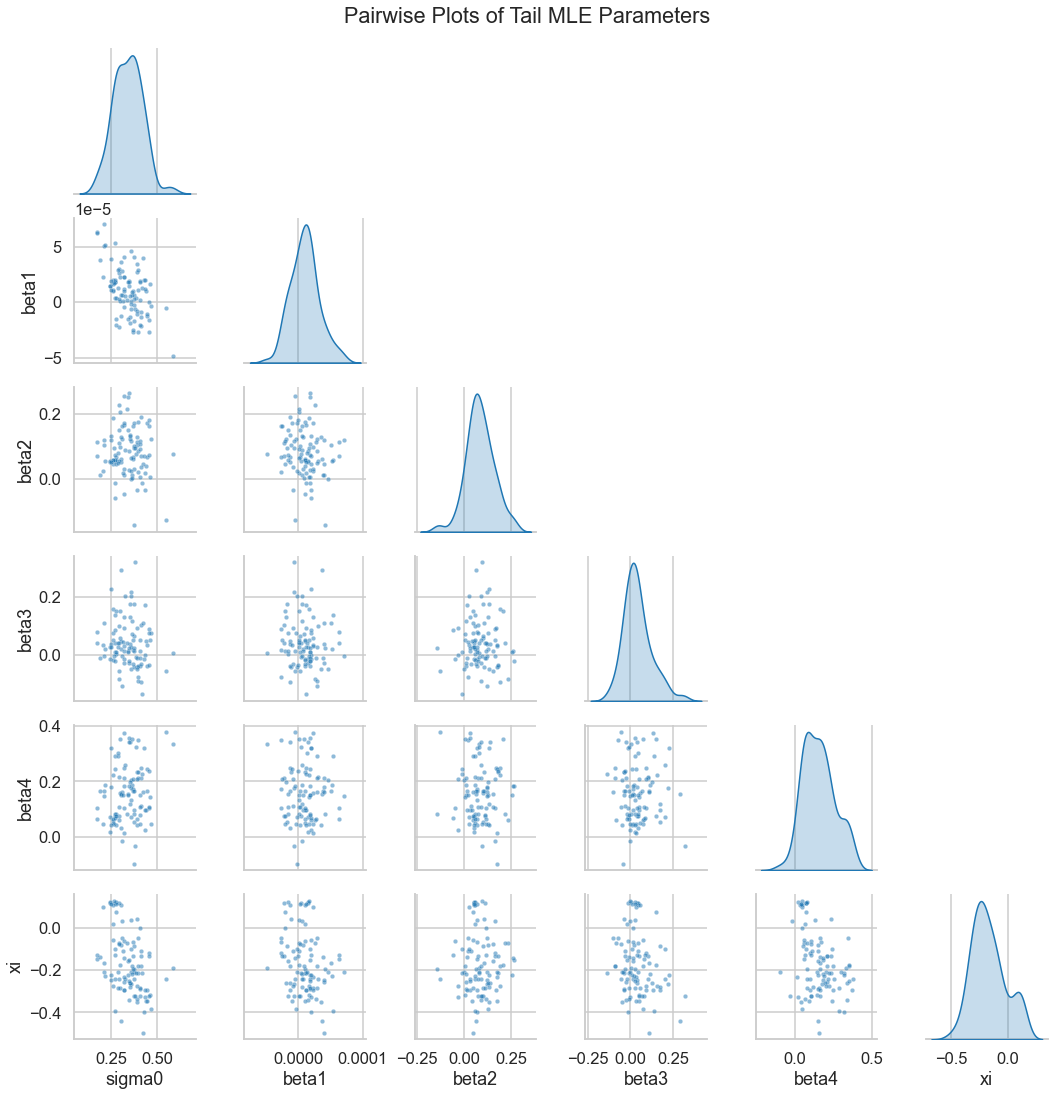

In [171]:
df = pd.DataFrame(
    boot_estimates,
    columns=['sigma0','beta1','beta2','beta3','beta4','xi']
)

# Correlation matrix
corr = df.corr()
#print(corr)

# Heatmap of correlations
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Parameter Correlation Matrix")
plt.tight_layout()
plt.show()

# Pairwise scatter‐matrix
sns.pairplot(df, diag_kind='kde', corner=True,
             plot_kws={'alpha':0.5, 's':20})
plt.suptitle("Pairwise Plots of Tail MLE Parameters", y=1.02)
plt.show()